In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [40]:
ma = 250

In [58]:
interval = '1h'
btc_data = pd.read_csv(f'data/btc_{interval}_data_with_ma.csv', index_col=False)
btc_data['timestamp'] = pd.to_datetime(btc_data['timestamp'])

In [59]:
def calculate_rsi(df, window=14):
    delta = df['close'].diff(1)  # Price changes between each day
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()  # Calculate average gains
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()  # Calculate average losses
    rs = gain / loss  # Relative Strength (RS)
    rsi = 100 - (100 / (1 + rs))  # RSI formula
    df['RSI'] = rsi
    return df

In [62]:
# Updated Backtest Function with RSI logic
def backtest_and_calculate_profit(df, ma, standard_rsi):
    df = calculate_rsi(df)  # Calculate RSI before the loop

    df['Position'] = np.where(df['close'] > df[f'MA_{ma}'], 1, 0)  # 1 for buy, 0 for sell
    df['Signal'] = df['Position'].diff()  # Buy signal when diff > 0, sell signal when diff < 0

    # Initial values
    initial_cash = 10000  # Starting with $10,000
    btc_holding = 0
    cash = initial_cash
    purchase_price = 0
    # stop_loss = 0.995  # Stop loss set at 0.5% loss (you can modify this)
    stop_loss = 0.99 # 1% loss

    for i in range(0, len(df)):
        price = df['close'].iloc[i]
        rsi = df['RSI'].iloc[i]

        # Stop loss check: Sell if the price drops more than stop_loss percentage below the purchase price
        if btc_holding > 0 and price < purchase_price * stop_loss:
            sell_price = price
            cash = btc_holding * sell_price  # Sell all BTC and hold cash
            btc_holding = 0  # No BTC left after selling
            current_time = df['timestamp'].iloc[i]
            print(f"{current_time}: Stop loss triggered! Sold BTC at {sell_price:,.2f}, now holding {cash:,.2f} USDT")

        else:
            # Buy signal if the price crosses above MA and RSI is below 30 (oversold condition)
            if df['Signal'].iloc[i] == 1:  # Buy when price crosses above MA
                if rsi > standard_rsi:
                    continue
                if cash > 0:
                    purchase_price = price
                    btc_holding = cash / purchase_price  # Buy BTC with all available cash
                    cash = 0  # No cash left after buying
                    current_time = df['timestamp'].iloc[i]
                    print(f"{current_time}: Bought BTC at {purchase_price:,.2f}, holding {btc_holding:.4f} BTC (RSI: {rsi:.2f})")

            # Sell signal if the price crosses below MA or RSI is above 70 (overbought condition)
            elif df['Signal'].iloc[i] == -1:  # Sell when price crosses below MA
                if btc_holding > 0:
                    sell_price = price
                    cash = btc_holding * sell_price  # Sell all BTC and hold cash
                    btc_holding = 0  # No BTC left after selling
                    current_time = df['timestamp'].iloc[i]
                    print(f"{current_time}: Sold BTC at {sell_price:,.2f}, now holding {cash:,.2f} USDT (RSI: {rsi:.2f})\n")
        
        # Calculate current portfolio value (cash + value of BTC)
        portfolio_value = cash + (btc_holding * price)
        # Update the portfolio value for each iteration
        df.loc[i, 'portfolio_value'] = portfolio_value

    # Drop 'Signal' and 'Position' columns
    df = df.drop(columns=['Signal', 'Position'])

    return df

### Find max value

In [47]:
print (f"interval: {interval}")

for ma, value in portfolio_value_by_ma.items():
    print(f"Final value for MA {ma}: {value:,.2f} USDT") 

# Find the MA with the highest portfolio value
best_ma = max(portfolio_value_by_ma, key=portfolio_value_by_ma.get)
best_value = portfolio_value_by_ma[best_ma]

print(f"The best performing for {interval} is {best_ma} MA with a final portfolio value of {best_value:,.2f} USDT")


interval: 2h
Final value for MA 10: 39,377.48 USDT
Final value for MA 20: 43,675.16 USDT
Final value for MA 30: 233,779.09 USDT
Final value for MA 50: 256,764.36 USDT
Final value for MA 60: 312,290.64 USDT
Final value for MA 90: 236,786.19 USDT
Final value for MA 100: 176,316.66 USDT
Final value for MA 110: 240,948.29 USDT
Final value for MA 120: 163,735.94 USDT
Final value for MA 130: 157,069.38 USDT
Final value for MA 140: 153,797.19 USDT
Final value for MA 150: 104,794.17 USDT
Final value for MA 160: 140,221.69 USDT
Final value for MA 170: 111,519.98 USDT
Final value for MA 180: 116,156.41 USDT
Final value for MA 200: 196,801.69 USDT
The best performing for 2h is 60 MA with a final portfolio value of 312,290.64 USDT


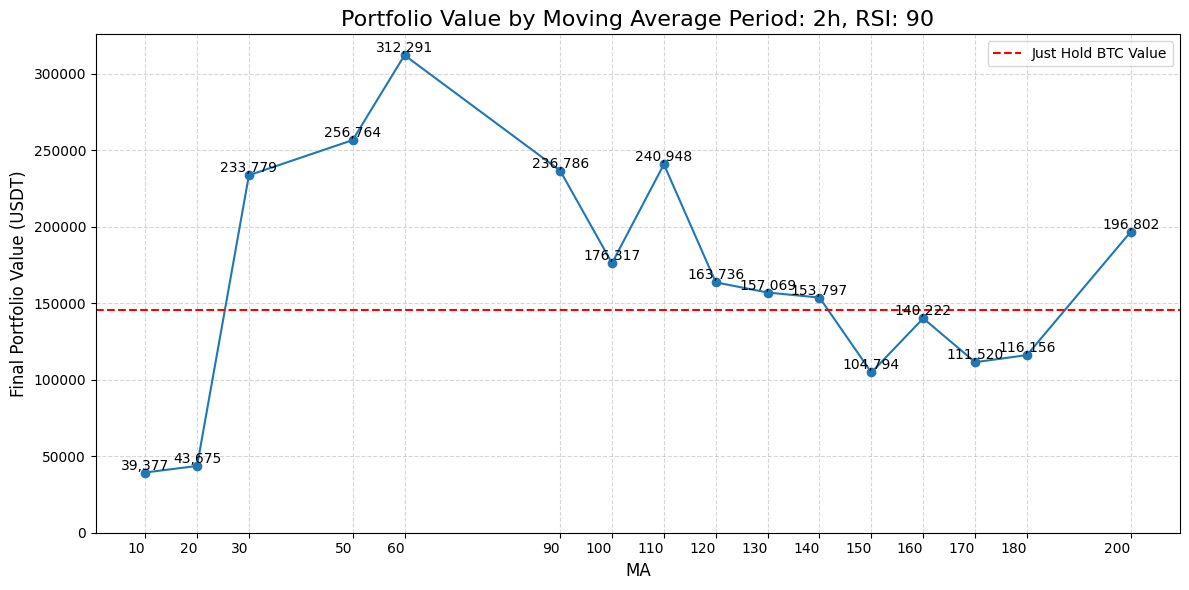

In [48]:
# Sort the dictionary by MA values
sorted_portfolio_value = dict(sorted(portfolio_value_by_ma.items()))

# Extract MA values and corresponding portfolio values
ma_values = list(sorted_portfolio_value.keys())
portfolio_values = list(sorted_portfolio_value.values())

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(ma_values, portfolio_values, marker='o')

# Customize the plot
plt.title(f'Portfolio Value by Moving Average Period: {interval}, RSI: {standard_rsi}', fontsize=16)
plt.xlabel('MA', fontsize=12)
plt.ylabel('Final Portfolio Value (USDT)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Add value labels on top of each point
for i, value in enumerate(portfolio_values):
    plt.text(ma_values[i], value, f'{value:,.0f}', ha='center', va='bottom')

# Add x-axis labels for each MA value
plt.xticks(ma_values, [f'{ma}' for ma in ma_values], rotation=0, ha='right')

# Adjust the bottom margin to accommodate the labels
plt.subplots_adjust(bottom=0.2)

# Add a horizontal line at 145,580.15
plt.axhline(y=145580.15, color='red', linestyle='--', label='Just Hold BTC Value')
plt.legend()

# Adjust y-axis to start from 0
plt.ylim(bottom=0)

# Show the plot
plt.tight_layout()
plt.show()


## Find best RSI

In [53]:
ma = 250
portfolio_value_by_rsi = {}

for rsi in range(60, 100):
    profit_df = backtest_and_calculate_profit(btc_data, ma, rsi)
    portfolio_value = profit_df['portfolio_value'].iloc[-1]
    # print(f"Final value interval {interval} for {ma} MA: {portfolio_value:,.2f} USDT")
    portfolio_value_by_rsi[rsi] = portfolio_value

2017-09-07 02:00:00: Bought BTC at 4,484.03, holding 2.2301 BTC (RSI: 52.63)
2017-09-08 12:00:00: Stop loss triggered! Sold BTC at 4,353.05, now holding 9,707.90 USDT
2017-09-09 04:00:00: Bought BTC at 4,385.26, holding 2.2138 BTC (RSI: 39.22)
2017-09-09 06:00:00: Stop loss triggered! Sold BTC at 4,321.52, now holding 9,566.79 USDT
2017-09-27 02:00:00: Bought BTC at 3,947.00, holding 2.4238 BTC (RSI: 52.83)
2017-11-11 10:00:00: Sold BTC at 6,410.02, now holding 15,536.69 USDT (RSI: 23.95)

2017-12-21 20:00:00: Bought BTC at 15,395.00, holding 1.0092 BTC (RSI: 36.02)
2017-12-22 00:00:00: Stop loss triggered! Sold BTC at 14,330.00, now holding 14,461.89 USDT
2018-01-08 10:00:00: Bought BTC at 15,400.00, holding 0.9391 BTC (RSI: 33.74)
2018-01-08 12:00:00: Stop loss triggered! Sold BTC at 14,609.88, now holding 13,719.90 USDT
2018-01-08 18:00:00: Bought BTC at 15,196.55, holding 0.9028 BTC (RSI: 39.14)
2018-01-08 20:00:00: Stop loss triggered! Sold BTC at 14,888.97, now holding 13,442.21 

In [54]:
for rsi, value in portfolio_value_by_rsi.items():
    print(f"Final value for rsi {rsi}: {value:,.2f} USDT") 

# Find the MA with the highest portfolio value
best_rsi = max(portfolio_value_by_rsi, key=portfolio_value_by_rsi.get)
best_value = portfolio_value_by_rsi[best_rsi]

print(f"The best performing for {interval} {ma} MA is RSI {best_rsi} with a final portfolio value of {best_value:,.2f} USDT")


Final value for rsi 60: 35,617.69 USDT
Final value for rsi 61: 35,385.46 USDT
Final value for rsi 62: 33,602.58 USDT
Final value for rsi 63: 33,396.54 USDT
Final value for rsi 64: 30,952.88 USDT
Final value for rsi 65: 30,439.06 USDT
Final value for rsi 66: 59,373.00 USDT
Final value for rsi 67: 55,681.23 USDT
Final value for rsi 68: 54,170.11 USDT
Final value for rsi 69: 75,424.41 USDT
Final value for rsi 70: 73,343.60 USDT
Final value for rsi 71: 89,655.46 USDT
Final value for rsi 72: 145,445.09 USDT
Final value for rsi 73: 181,529.78 USDT
Final value for rsi 74: 172,935.85 USDT
Final value for rsi 75: 218,152.15 USDT
Final value for rsi 76: 217,807.10 USDT
Final value for rsi 77: 369,070.78 USDT
Final value for rsi 78: 369,070.78 USDT
Final value for rsi 79: 378,861.77 USDT
Final value for rsi 80: 378,861.77 USDT
Final value for rsi 81: 369,642.92 USDT
Final value for rsi 82: 369,642.92 USDT
Final value for rsi 83: 403,383.05 USDT
Final value for rsi 84: 400,667.25 USDT
Final value 

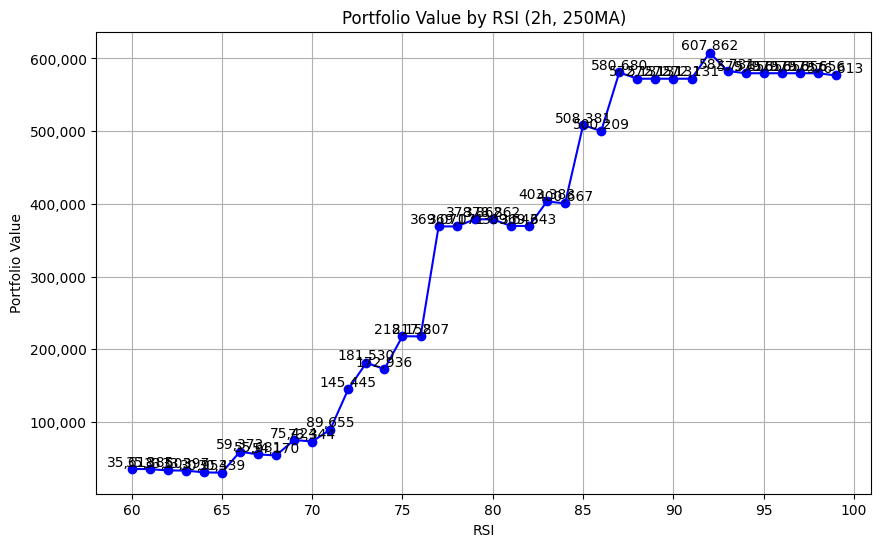

In [55]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Assuming portfolio_value_by_ma is your dictionary
# The keys are the MA values and the values are the corresponding portfolio values

# Extracting the keys and values from the dictionary
ma_values = list(portfolio_value_by_rsi.keys())
portfolio_values = list(portfolio_value_by_rsi.values())

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(ma_values, portfolio_values, marker='o', linestyle='-', color='b')

plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format ticks with commas

for i, value in enumerate(portfolio_values):
    plt.text(ma_values[i], value, f'{value:,.0f}', ha='center', va='bottom')

# Adding labels and title
plt.xlabel('RSI')
plt.ylabel('Portfolio Value')
plt.title(f'Portfolio Value by RSI ({interval}, {ma}MA)')

# Displaying the plot
plt.grid(True)
plt.show()

## Test all MA candidates using Best RSI

In [56]:
# best_rsi = 90
portfolio_value_by_ma = {}
ma_candidates = [10, 20, 30, 50, 60, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300]
for ma in ma_candidates:
    profit = backtest_and_calculate_profit(btc_data, ma, best_rsi)
    portfolio_value_by_ma[ma] = profit['portfolio_value'].iloc[-1]

2017-08-18 08:00:00: Bought BTC at 4,304.15, holding 2.3233 BTC (RSI: 49.02)
2017-08-18 12:00:00: Sold BTC at 4,293.09, now holding 9,974.30 USDT (RSI: 35.57)

2017-08-19 18:00:00: Bought BTC at 4,076.12, holding 2.4470 BTC (RSI: 41.53)
2017-08-20 12:00:00: Sold BTC at 4,063.35, now holding 9,943.06 USDT (RSI: 49.63)

2017-08-20 14:00:00: Bought BTC at 4,125.00, holding 2.4104 BTC (RSI: 63.80)
2017-08-20 22:00:00: Stop loss triggered! Sold BTC at 4,086.29, now holding 9,849.75 USDT
2017-08-21 20:00:00: Bought BTC at 4,039.10, holding 2.4386 BTC (RSI: 40.61)
2017-08-21 22:00:00: Stop loss triggered! Sold BTC at 4,016.00, now holding 9,793.42 USDT
2017-08-22 08:00:00: Bought BTC at 3,904.56, holding 2.5082 BTC (RSI: 45.66)
2017-08-22 10:00:00: Stop loss triggered! Sold BTC at 3,866.48, now holding 9,697.90 USDT
2017-08-22 12:00:00: Bought BTC at 3,920.99, holding 2.4733 BTC (RSI: 44.24)
2017-08-22 14:00:00: Stop loss triggered! Sold BTC at 3,858.23, now holding 9,542.68 USDT
2017-08-22 1

In [64]:
print (f"interval: {interval}")

for ma, value in portfolio_value_by_ma.items():
    print(f"Final value for MA {ma}: {value:,.2f} USDT") 

# Find the MA with the highest portfolio value
best_ma = max(portfolio_value_by_ma, key=portfolio_value_by_ma.get)
best_value = portfolio_value_by_ma[best_ma]

print(f"The best performing for {interval} is {best_ma} MA and with a final portfolio value of {best_value:,.2f} USDT")


interval: 1h
Final value for MA 10: 39,377.48 USDT
Final value for MA 20: 43,675.16 USDT
Final value for MA 30: 233,779.09 USDT
Final value for MA 50: 256,764.36 USDT
Final value for MA 60: 312,290.64 USDT
Final value for MA 90: 236,786.19 USDT
Final value for MA 100: 176,316.66 USDT
Final value for MA 110: 240,948.29 USDT
Final value for MA 120: 163,735.94 USDT
Final value for MA 130: 157,069.38 USDT
Final value for MA 140: 153,797.19 USDT
Final value for MA 150: 104,794.17 USDT
Final value for MA 160: 140,221.69 USDT
Final value for MA 170: 111,519.98 USDT
Final value for MA 180: 116,156.41 USDT
Final value for MA 200: 196,801.69 USDT
Final value for MA 210: 288,400.07 USDT
Final value for MA 220: 253,623.94 USDT
Final value for MA 230: 359,894.91 USDT
Final value for MA 240: 379,060.50 USDT
Final value for MA 250: 572,131.11 USDT
Final value for MA 260: 611,963.94 USDT
Final value for MA 270: 616,669.55 USDT
Final value for MA 280: 383,283.09 USDT
Final value for MA 290: 173,615.68 